In [1]:
#for the packages import
import os
import sys
import pickle
import random
import PIL
import cv2

import numpy as np
import pandas as pd

!pip3 install tensorflow==1.14.0
import tensorflow as tf
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
# !pip install tf_slim
import tensorflow.contrib.slim as slim

# from tensorflow.contrib import slim as contrib_slim

import matplotlib.pyplot as plt

np.random.seed(1)
tf.set_random_seed(1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [11]:
#for the dataloading
!pip install patool
import patoolib

patoolib.extract_archive("/content/drive/My Drive/Building_Results/Counting_Problem/counting_dataset.rar", outdir="/content/")

     |████████████████████████████████| 81kB 5.4MB/s 
patool: Extracting /content/drive/My Drive/Building_Results/Counting_Problem/counting_dataset.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/Building_Results/Counting_Problem/counting_dataset.rar"
patool:     with cwd='/content/'
patool: ... /content/drive/My Drive/Building_Results/Counting_Problem/counting_dataset.rar extracted to `/content/'.


'/content/'

In [12]:
#copying form the google drive to colab drive
%cp -av '/content/drive/My Drive/Building_Results/Counting_Problem/train_gt.txt' '/content'
%cp -av '/content/drive/My Drive/Building_Results/Counting_Problem/test_gt.txt' '/content'

'/content/drive/My Drive/Building_Results/Counting_Problem/train_gt.txt' -> '/content/train_gt.txt'
'/content/drive/My Drive/Building_Results/Counting_Problem/test_gt.txt' -> '/content/test_gt.txt'


In [2]:
def get_dataframe(text_file_path):
  #for saving the data
  name_list = []
  count_list = []

  #for opening the file and extracting the data
  text_file = open(text_file_path, 'r') 
  Lines = text_file.readlines() 
  for line in Lines:
    temp = line.split(' ')
    name_list.append(temp[0])
    count_list.append(int(temp[1]))

  #for creating the dataframe
  data = {'filename': name_list, 'count': count_list}
  my_dataframe = pd.DataFrame(data, columns=['filename', 'count'])
  return my_dataframe

#for calling the methods
training_df = get_dataframe('/content/train_gt.txt')
testing_df = get_dataframe('/content/test_gt.txt')

In [3]:
training_df.head()

,filename,count
0,khi_650_l,13
1,khi_480_r,10
2,isb_500_r,0
3,RDH_3651_z19_u,33
4,khi_788_u,3


In [4]:
testing_df.head()

,filename,count
0,khi_894,0
1,khi_353,5
2,khi_589,1
3,RDH_1266_z19,40
4,RDH_231_z19,30


In [5]:
def load_data(record_df, DATA_PATH, image_size=128):
  #==================================== laoding the data
  X = []
  Y = []

  count = 0
  for row in record_df.itertuples():
    #for getting the image
    img = cv2.imread(os.path.join(DATA_PATH, row.filename + ".tiff"))
    img = cv2.resize(img, (image_size, image_size), interpolation=cv2.INTER_AREA)
    img = np.array(img)
    X.append(img)
    
    #for getting the labels
    Y.append(row.count)

    count += 1
    if(count % 100 == 0):
      print('currently at: ', count)    

  X = np.array(X).astype('float32')
  Y = np.array(Y).astype('float32')
  return X, Y

In [7]:
train_x, train_y = load_data(training_df, '/content/data_upload/train')
test_x, test_y = load_data(testing_df, '/content/data_upload/test')

#=================================================== for examples
# calculating the mean and standard dev on training set
# (as validation set will also be from the same distribution)
mean = np.mean(train_x)
std = np.std(train_x)

# === normalizing the training set
train_x -= mean
train_x /= std

#normalizing the mask (from 0-1)
train_x /= 255

# === normalizing the training set
test_x -= mean
test_x /= std

#normalizing the mask (from 0-1)
test_x /= 255
#=================================================== for labels
mean = np.mean(train_y)
std = np.std(train_y)

# === normalizing the training set
train_y -= mean
train_y /= std

# === normalizing the training set
test_y -= mean
test_y /= std

#dividing the test data into validation and test form
size = int(len(test_x) / 2)
validate_x = test_x[:size]
validate_y = test_y[:size]

test_x =  test_x[size:]
test_y = test_y[size:]

#Reshaping
trainY = train_y.reshape((-1,1))
validateY= validate_y.reshape((-1,1))
testY = test_y.reshape((-1,1))


print(train_x.shape, train_y.shape)
print(validate_x.shape, validate_y.shape)
print(test_x.shape, test_y.shape)

(10755, 128, 128, 3) (10755,)
(133, 128, 128, 3) (133,)
(133, 128, 128, 3) (133,)


In [9]:
# Deep Q Network off-policy
class Network(object):
    def __init__(
            self, n_output=2, n_length=128, learning_rate=0.01, batch_size=32, channel = 1,
            output_graph=False, use_ckpt = True):

        self.n_length = n_length # width or height of input matrix
        self.lr = learning_rate
        self.batch_size = batch_size
        self.channel = channel # num of channel
        self.learn_step_counter = 0
        self.global_step = tf.Variable(tf.constant(1))
        self.global_counter = 1 # equal to self.global_step
        self.n_output = n_output
        self._build_net()
        self.model_vars = None

        # e_params = tf.get_collection('eval_net_params')

        # self.replace_target_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]
        # self.replace_eval_op = [tf.assign(e, t) for e, t in zip(e_params,t_params)]
        # assign e to t

        self.sess = tf.Session()
        self.saver = tf.train.Saver(tf.global_variables())
        self.dir_path = '/content'#os.path.dirname(os.path.realpath(__file__))

        if output_graph:
            # tensorboard --logdir=logs
            tf.summary.FileWriter("logs/", self.sess.graph)

        if use_ckpt:
            self.restore_parameters()
        else:
            self.sess.run(tf.global_variables_initializer()) # train step

        self.cost_his = []

    def conv2d(self,x, W, stride,pad):
        # stride [1, x_movement, y_movement, 1]
        # Must have strides[0] = strides[3] = 1
        return tf.nn.conv2d(x, W, strides = stride, padding=pad)

    def max_pool(self,x,k,stride,pad):
        # stride [1, x_movement, y_movement, 1]
        return tf.nn.max_pool(x, ksize=k, strides=stride, padding=pad)

    def BN_fc(self,x,dim):
        # x is input size,dim is batch size
        mean_value,var_value = tf.nn.moments(x,[0])
        scales = tf.Variable(tf.ones([dim]))
        betas = tf.Variable(tf.zeros([dim]))
        epsilon = 1e-3
        return tf.nn.batch_normalization(x,mean_value,var_value,scales,betas,epsilon)


    def _build_net(self):
        # ------------------ build Gender_Net ------------------
        self.xs = tf.placeholder(tf.float32, [None, self.n_length, self.n_length, self.channel], name='s')  # input
        # self.s = tf.reshape(self.xs, [-1, self.n_features, self.n_features, self.channel])
        # self.keep_prob = tf.placeholder(tf.float32)
        self.labels = tf.placeholder(tf.float32,[None,self.n_output],name='age_labels')

        with tf.variable_scope('gender_net'):
            # c_names(collections_names) are the collections to store variables
            c_names, w_initializer, b_initializer = \
                ['gender_net_params', tf.GraphKeys.GLOBAL_VARIABLES], \
                tf.truncated_normal_initializer(0., 0.1), tf.constant_initializer(0.1)  # config of layers

            # first layer. collections is used later when assign to target net
            with tf.variable_scope('convol1'):
                w1_conv = tf.get_variable('w1_conv', [7,7,self.channel,32], initializer=w_initializer, collections=c_names)
                b1_conv = tf.get_variable('b1_conv', [1,32], initializer=b_initializer, collections=c_names)
                h_conv1 = tf.nn.relu(self.conv2d(self.xs, w1_conv,stride=[1,2,2,1],pad='SAME') + b1_conv)  # output size 64*64*32
                lrn1 = tf.nn.local_response_normalization(h_conv1, alpha=0.0001, beta=0.75)
                h_pool1 = self.max_pool(lrn1,k=[1,3,3,1],stride=[1,2,2,1],pad='SAME') # output size 32*32*32

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('convol2'):
                w2_conv = tf.get_variable('w2_conv', [5,5,32,64], initializer=w_initializer, collections=c_names)
                b2_conv = tf.get_variable('b2_conv', [1,64], initializer=b_initializer, collections=c_names)
                h_conv2 = tf.nn.relu(self.conv2d(h_pool1, w2_conv,stride=[1,1,1,1],pad='SAME') + b2_conv)  # output size 32*32*64
                lrn2 = tf.nn.local_response_normalization(h_conv2, alpha=0.0001, beta=0.75)
                h_pool2 = self.max_pool(lrn2,k=[1,3,3,1],stride=[1,2,2,1],pad='SAME') # output 16*16*64

            with tf.variable_scope('convol3'):
                w3_conv = tf.get_variable('w2_conv', [3,3,64,64], initializer=w_initializer, collections=c_names)
                b3_conv = tf.get_variable('b2_conv', [1,64], initializer=b_initializer, collections=c_names)
                h_conv3 = tf.nn.relu(self.conv2d(h_pool2, w3_conv,stride=[1,1,1,1],pad='SAME') + b3_conv)  # output size 16*16*64
                # lrn3 = tf.nn.local_response_normalization(h_conv3, alpha=0.0001, beta=0.75)
                h_pool3 = self.max_pool(h_conv3,k=[1,3,3,1],stride=[1,2,2,1],pad='SAME') # output 8*8*64

            # fully connected layer 1
            with tf.variable_scope('fyl1'):
                w1_fu = tf.get_variable('w1_fu',[8*8*64,512],initializer=w_initializer, collections=c_names)
                b1_fu = tf.get_variable('b1_fu',[1,512],initializer=b_initializer, collections=c_names)
                h_pool3_flat = tf.reshape(h_pool3, [-1, 8*8*64])
                bn_in_fc1 = tf.matmul(h_pool3_flat, w1_fu) + b1_fu
                # bn_out_fc1 = self.BN_fc(bn_in_fc1,512)
                h_fc1 = tf.nn.relu(bn_in_fc1)
                # h_fc1_drop = tf.nn.dropout(h_fc1, self.keep_prob)

            # fully connected layer 2,gender
            with tf.variable_scope('fyl2_pro'):
                w2_fu = tf.get_variable('w2_fu_pro', [512,self.n_output], initializer=w_initializer, collections=c_names)
                b2_fu = tf.get_variable('b2_fu_pro', [1,self.n_output], initializer=b_initializer, collections=c_names)
                pro = tf.matmul(h_fc1, w2_fu) + b2_fu
                # self.q_eval = self.BN_fc(bn_in_fc2, self.n_actions)
                self.val_output = tf.nn.sigmoid(pro) #softmax(pro)
                self.model_vars = tf.trainable_variables()

        with tf.variable_scope('loss'):

            # corss entropy
            # cross_entropy = -tf.reduce_mean(self.labels*tf.log(self.val_output))
            # self.loss = softmax_cross_entropy_with_logits(self.labels,self.val_output)
            # cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.val_output))
            cross_entropy = tf.compat.v1.losses.mean_squared_error(
                self.labels, self.val_output, weights=1.0, scope=None,
                loss_collection=tf.GraphKeys.LOSSES)

            # L2 regularization for the fully connected parameters.
            regularizers = (
                            tf.nn.l2_loss(w2_fu) + tf.nn.l2_loss(b2_fu) +
                            tf.nn.l2_loss(w1_fu) + tf.nn.l2_loss(b1_fu) +
                            tf.nn.l2_loss(w3_conv) + tf.nn.l2_loss(b3_conv) +
                            tf.nn.l2_loss(w2_conv) + tf.nn.l2_loss(b2_conv) +
                            tf.nn.l2_loss(w1_conv) + tf.nn.l2_loss(b1_conv)
                            )
            self.loss = cross_entropy + 5e-4 *regularizers

        with tf.variable_scope('train'):
            learning_rate = tf.train.exponential_decay(
                self.lr,  # Base learning rate.
                #batch * self.batch_size,  # Current index into the dataset.
                self.global_step,
                5000,  # Decay step.
                0.98,  # Decay rate.
                staircase=True)
            self._train_op = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(self.loss, global_step=self.global_step)

            # self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss) # normal training
            # self._train_op = tf.train.MomentumOptimizer(self.lr,0.9).minimize(self.loss)
            # learning_rate = tf.train.exponential_decay(learning_rate=self.lr, global_step=self.global_step,
            #                                            decay_steps=10000, decay_rate=0.96, staircase=True)
            # grad_norm = 8
            # tvars = tf.trainable_variables()
            # grads,_ = tf.clip_by_global_norm(tf.gradients(self.loss,tvars),grad_norm) # adding clipping
            # opt = tf.train.RMSPropOptimizer(self.lr)
            # self._train_op = opt.apply_gradients(zip(grads,tvars))
    
    def model_summary(self):
        slim.model_analyzer.analyze_vars(self.model_vars, print_info=True)
    
    def accuracy(self,predictions, labels):
        """
        Get accuracy
        :param predictions:
        :param labels:
        :return: accuracy
        """
        size = labels.shape[0]
        return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
                / size)

    def get_accuracy_rate(self,x,y):
        cost,predictions = self.sess.run([self.loss,self.val_output],
                                                  feed_dict={
                                                      self.labels: y,
                                                      self.xs: x
                                                    })
        accu_rate = self.accuracy(predictions, y)
        return cost, accu_rate

    def learn(self,x,y):
        # train eval network
        _, self.cost= self.sess.run([self._train_op, self.loss],
                                     feed_dict={self.labels: y,
                                                self.xs: x
                                                })
        self.global_counter +=1
        if self.global_counter%10==0:
            self.cost_his.append(self.cost)

    def plot_cost(self):
        """
        This function will plot cost histgram
        :return:
        """
        import matplotlib.pyplot as plt

        plt.figure()
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylabel('Cost')
        plt.xlabel('Training Steps')
        plt.grid()
        # plt.show()
        plt.savefig('cost.png')

    def restore_parameters(self):
        """
        This function will restore weights
        :return:
        """
        self.saver.restore(self.sess, self.dir_path + '/weights_saved/model.ckpt')  # restore model

    def save_parameters(self):
        """
        This function will save weights
        :return:
        """
        saver = tf.train.Saver()
        if not os.path.exists(self.dir_path+"/weights_saved"):
            os.mkdir(self.dir_path + "/weights_saved")
        saver_path = saver.save(self.sess, self.dir_path+'/weights_saved/model.ckpt')  # save model into save/model.ckpt file
        print('Model saved in file:', saver_path)

In [20]:
def train_model():
	"""
	This function will train model
	Tips: Load test,validation data first
	Then, seperately load training data, since training data is really huge.
	:return:
	"""
  
	## extract different type data
	train_dataset = train_x
	train_age_labels = trainY

	valid_dataset = validate_x
	valid_age_labels = validateY

	test_dataset = test_x
	test_age_labels = testY

	hight = 128
	channel = 3
	batch_size = 64
	learn_rate = 0.003
	n_output = 1 # age mode
	total_size = train_dataset.shape[0]
	net = Network(
		n_output = n_output,
		n_length=hight,
		learning_rate=learn_rate,
		batch_size=batch_size,
		channel=channel,
		output_graph=False,
		use_ckpt=False
	)
 
	# net.model_summary()
 
	epoch = 10 # epoch
	iteration = int(total_size / batch_size)
	print(iteration)
	i = 1  # total training time
	accu_train_age = []
	accu_valid_age = []
	accu_test_age = []
	early_stop =0 # early stopping flag
	train_rate_age = 0

	for e in range(epoch):
		print("-------------------------------")
		print("epoch %d" % (e + 1))
		# randomly sample batch memory from all memory
		indices = np.random.permutation(total_size)
		for ite in range(iteration):
			mini_indices = indices[ite * batch_size:(ite + 1) * batch_size]
			batch_x = train_dataset[mini_indices]
			batch_y_age = train_age_labels[mini_indices]
			net.learn(batch_x, batch_y_age)

			if i % 50 == 0:
				cost, train_rate_age= net.get_accuracy_rate(batch_x, batch_y_age)
				print("Iteration: %i. Train loss %.5f, Minibatch gen accuracy:"" %.1f%%"% (i, cost, train_rate_age))
				accu_train_age.append(train_rate_age)

			if i % 50 == 0:
				cost, valid_rate_age = net.get_accuracy_rate(valid_dataset, valid_age_labels)
				print("Iteration: %i. Validation loss %.5f, Validation gen accuracy:" " %.1f%%" % (i, cost, valid_rate_age))
				accu_valid_age.append(valid_rate_age)

				cost, test_rate_age= net.get_accuracy_rate(test_dataset, test_age_labels)
				print("Iteration: %i. Test loss %.5f, Test gen accuracy:"" %.1f%%" % (i, cost, test_rate_age))
				accu_test_age.append(test_rate_age)

			if i % 20 == 0:
				net.save_parameters()

			i = i + 1
		# early stopping
		if train_rate_age == 100:
			if early_stop == 10:
				print("Early Stopping!")
				break
			else:
				early_stop = early_stop + 1

		net.plot_cost()  # plot trainingi cost

		plt.figure()  # plot accuracy
		plt.plot(np.arange(len(accu_train_age)), accu_train_age, label='train age', linestyle='--')
		plt.plot(np.arange(len(accu_valid_age)), accu_valid_age, label='valid age', linestyle='-')
		plt.plot(np.arange(len(accu_test_age)), accu_test_age, label='test age', linestyle=':')
		plt.ylabel('age accuracy')
		plt.xlabel('epoch')
		plt.legend(loc='lower right')
		plt.grid()
		plt.savefig('age.png')

168
-------------------------------
epoch 1
Model saved in file: /content/weights_saved/model.ckpt
Model saved in file: /content/weights_saved/model.ckpt
Iteration: 50. Train loss 4.81345, Minibatch gen accuracy: 100.0%
Iteration: 50. Validation loss 5.09392, Validation gen accuracy: 100.0%
Iteration: 50. Test loss 5.20850, Test gen accuracy: 100.0%
Model saved in file: /content/weights_saved/model.ckpt
Model saved in file: /content/weights_saved/model.ckpt
Iteration: 100. Train loss 5.15280, Minibatch gen accuracy: 100.0%
Iteration: 100. Validation loss 5.08758, Validation gen accuracy: 100.0%
Iteration: 100. Test loss 5.20216, Test gen accuracy: 100.0%
Model saved in file: /content/weights_saved/model.ckpt
Model saved in file: /content/weights_saved/model.ckpt
Model saved in file: /content/weights_saved/model.ckpt
Iteration: 150. Train loss 5.00452, Minibatch gen accuracy: 100.0%
Iteration: 150. Validation loss 5.08124, Validation gen accuracy: 100.0%
Iteration: 150. Test loss 5.1958

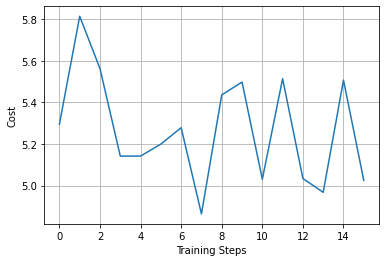

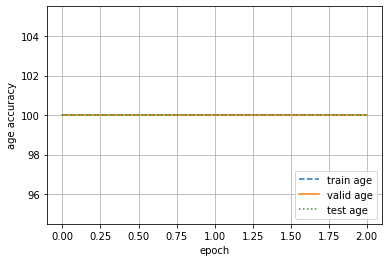

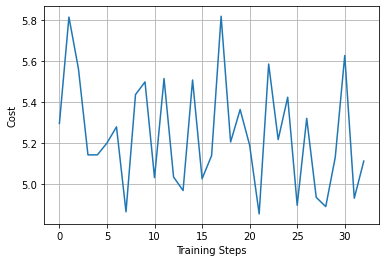

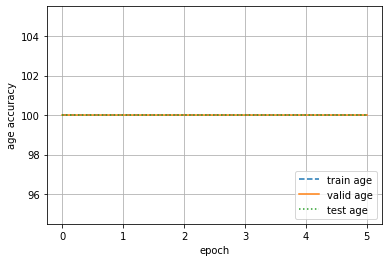

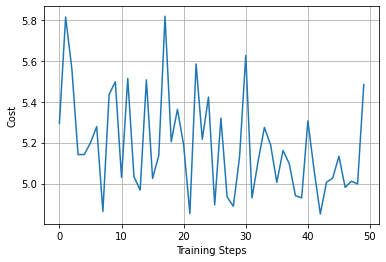

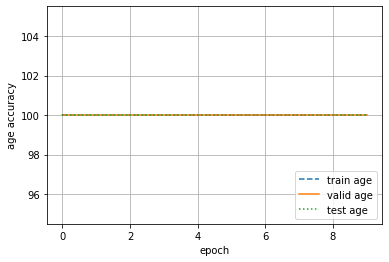

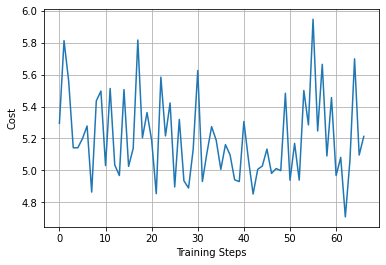

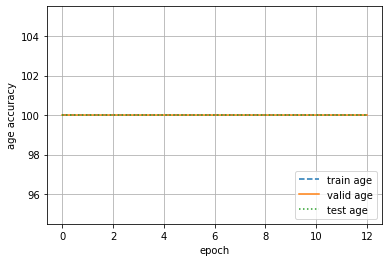

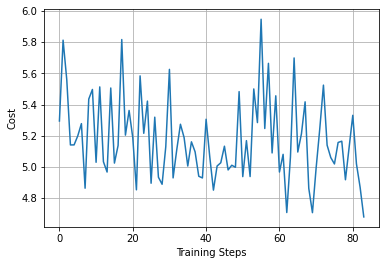

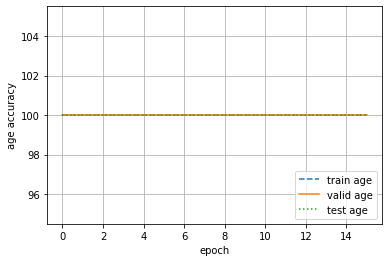

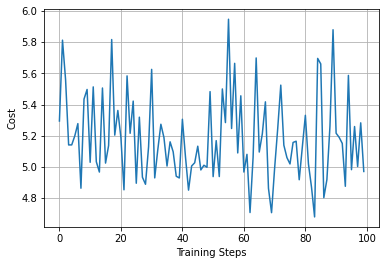

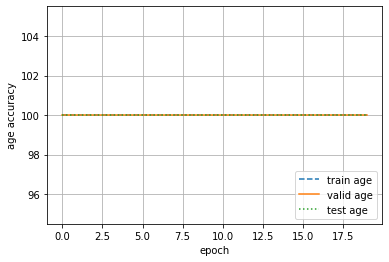

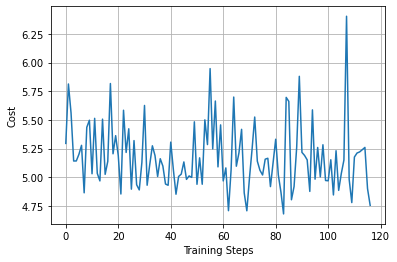

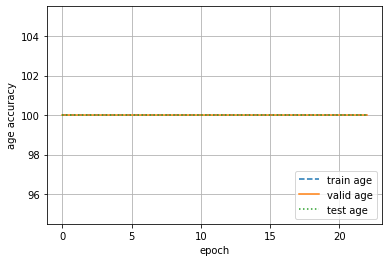

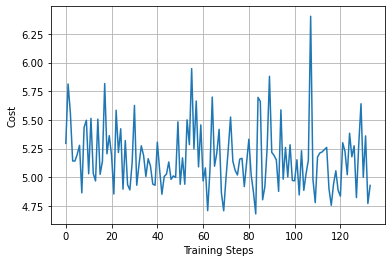

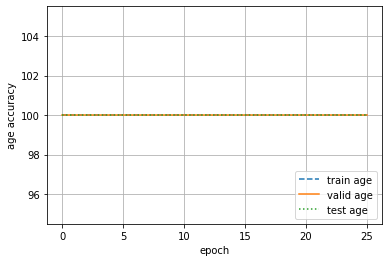

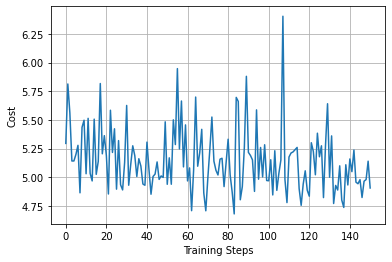

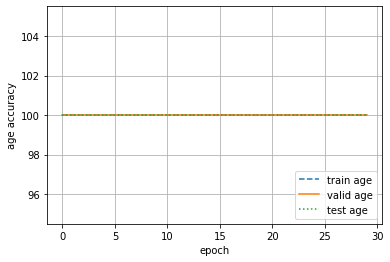

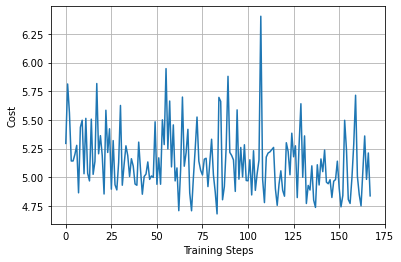

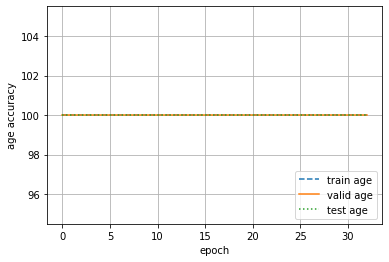

In [21]:
#for starting the training
tf.reset_default_graph()
train_model()